# Feature Importaces for XGBoost of the Baseline
In this section, we aim to gain a better understanding of the models and which features were most important for each language and the emotion detection decision.
We also hope to deepen our understanding of the languages themselves.

We calculate the feature importances, which indicate how important a feature is for a decision.
Furthermore, we calculate the SHAP values, which provide information about which features are important and in which direction they influence the predictions.

we also evaluate the feature importance here.


In [49]:
# dependencies
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt



In [50]:
# data
df_english = pd.read_csv(r"..\Data\English\features_english.csv")
df_german = pd.read_csv(r'..\Data\German\features_german.csv')
df_italian = pd.read_csv(r'..\Data\Italian\features_italian.csv')
df_urdu = pd.read_csv(r'..\Data\Urdu\features_urdu.csv')

languages = {
    'english': df_english,
    'german': df_german,
    'italian': df_italian,
    'urdu': df_urdu
}


We use our improved pipeline with standard scaling and SMOTE. Group K-Fold cross-validation is applied for all languages.

In [51]:

def separate_feats_labs(df):
    X = df.drop(["emotion", "speaker_id", "filename", "valence"], axis=1)  # Features
    y = df["valence"]  # Labels
    groups = df["speaker_id"]  

    if not df.equals(df_english):
        n_splits = 5
        gkf = GroupKFold(n_splits=n_splits)
    else:
        n_splits = 4
        gkf = GroupKFold(n_splits=n_splits)

    return X, y, groups, gkf, n_splits


def evaluate_features(X, y, groups, gkf, n_splits):
    
    # XGBoost-Pipeline mit StandardScaler und SMOTE
    xgb_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier(random_state=42))
    ])

    shap_values_all = []
    expected_values_all = []
    feature_importances = np.zeros(X.shape[1])

    # Cross-Validation
    for train_idx, val_idx in gkf.split(X, y, groups):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        
        xgb_pipeline.fit(X_train, y_train)

        model = xgb_pipeline.named_steps["classifier"]
        
        # get Feature-Importances 
        feature_importances += model.feature_importances_
        
        # calculate SHAP-Werte
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_val)  # SHAP-Werte für Validierungsdaten
        shap_values_all.append(shap_values.values)
        expected_values_all.append(explainer.expected_value)

    # Feature-Importances avergae
    feature_importances /= n_splits

    # combine SHAP-Werte 
    shap_values_combined = np.concatenate(shap_values_all, axis=0)

    return feature_importances, shap_values_combined, expected_values_all[0]




# German

In [ ]:
X, y, groups, gkf, n_splits = separate_feats_labs(df_german)
feature_importances, shap_values_combined,_= evaluate_features(X, y, groups, gkf, n_splits)

### Feature Importances

In [53]:
# Feature-Importance DataFrame 
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# Top 10 Feature-Importances 
feature_importance_df.head(10)


,Feature,Importance
76,alphaRatioUV_sma3nz_amean,0.046998
60,hammarbergIndexV_sma3nz_amean,0.042346
85,MeanUnvoicedSegmentLength,0.037549
58,alphaRatioV_sma3nz_amean,0.035454
51,F2amplitudeLogRelF0_sma3nz_stddevNorm,0.032018
22,mfcc1_sma3_amean,0.020365
30,jitterLocal_sma3nz_amean,0.020300
1,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,0.019484
32,shimmerLocaldB_sma3nz_amean,0.017842
11,loudness_sma3_stddevNorm,0.017813


### SHAP Values

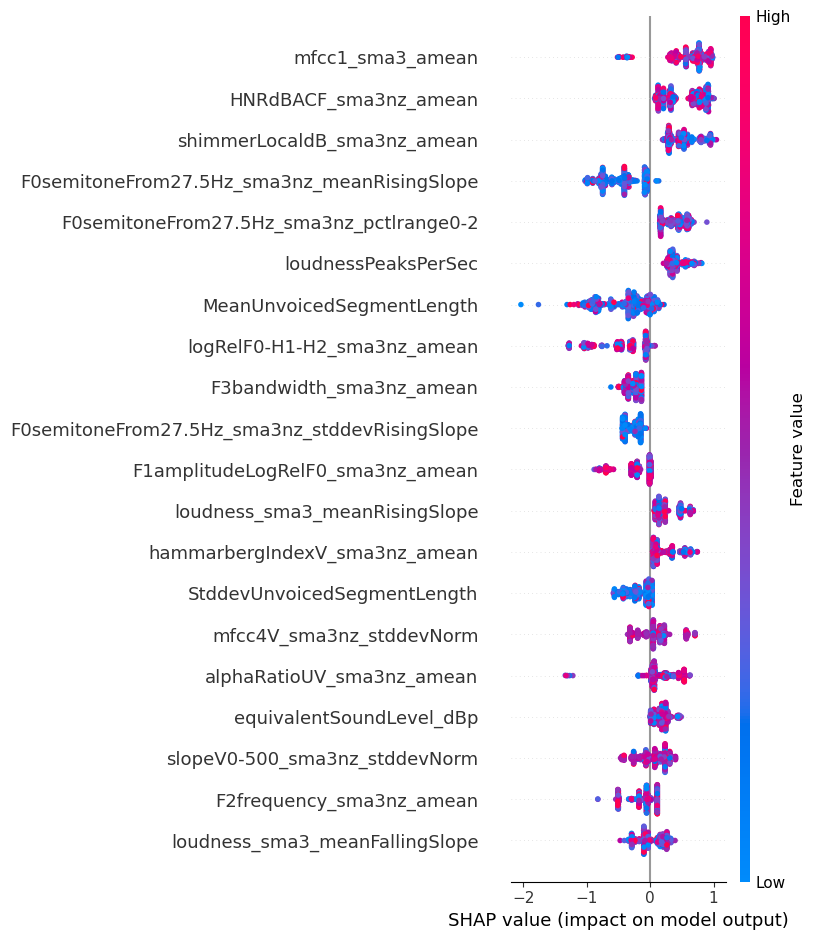

In [54]:
# SHAP Summary Plot
plt.figure(figsize=(6, 4))  # Adjust width and height
shap.summary_plot(shap_values_combined, features=X)

This shows how each feature contributes to the model’s predictions. Features are ranked by importance, with colors indicating whether high or low feature values.

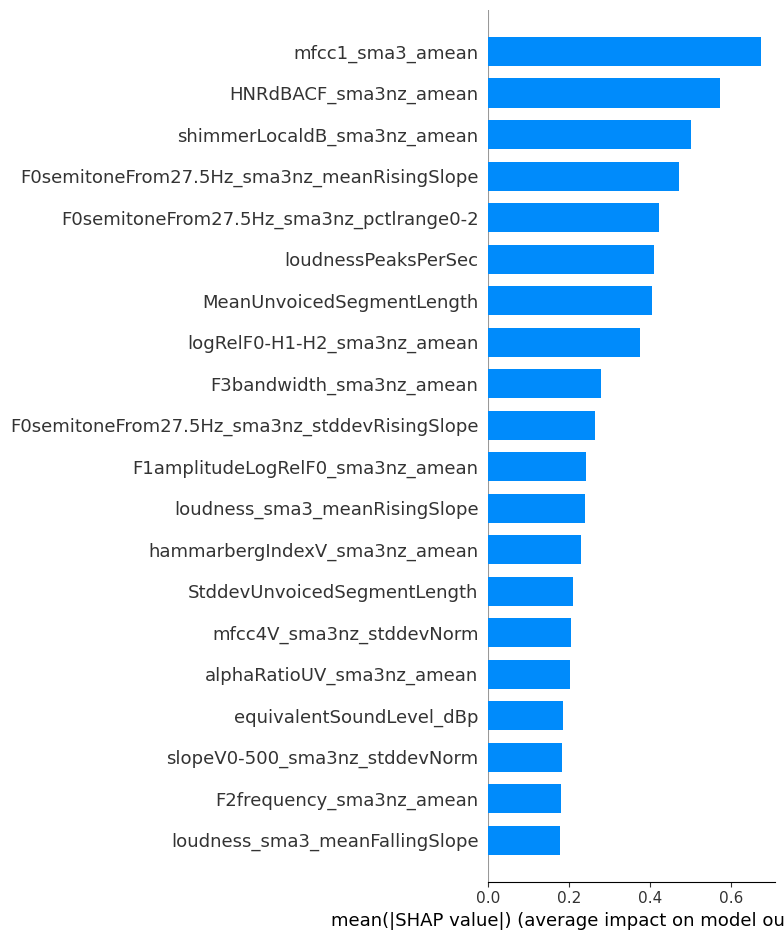

In [55]:
plt.figure(figsize=(3, 3))  
shap.summary_plot(shap_values_combined, features = X, plot_type="bar")


This is a bar chart ranking features by their average absolute SHAP value. It provides a straightforward way to see which features have the highest impact.

# Italian

In [56]:
X, y, groups, gkf, n_splits = separate_feats_labs(df_italian)
feature_importances, shap_values_combined,_= evaluate_features(X, y, groups, gkf, n_splits)
# Feature-Importance DataFrame 
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# Top 10 Feature-Importances 
feature_importance_df.head(10)


,Feature,Importance
51,F2amplitudeLogRelF0_sma3nz_stddevNorm,0.044274
57,F3amplitudeLogRelF0_sma3nz_stddevNorm,0.036500
14,loudness_sma3_percentile80.0,0.033061
24,mfcc2_sma3_amean,0.029482
65,slopeV500-1500_sma3nz_stddevNorm,0.029015
20,spectralFlux_sma3_amean,0.025077
16,loudness_sma3_meanRisingSlope,0.022226
87,equivalentSoundLevel_dBp,0.021041
50,F2amplitudeLogRelF0_sma3nz_amean,0.018852
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.018142


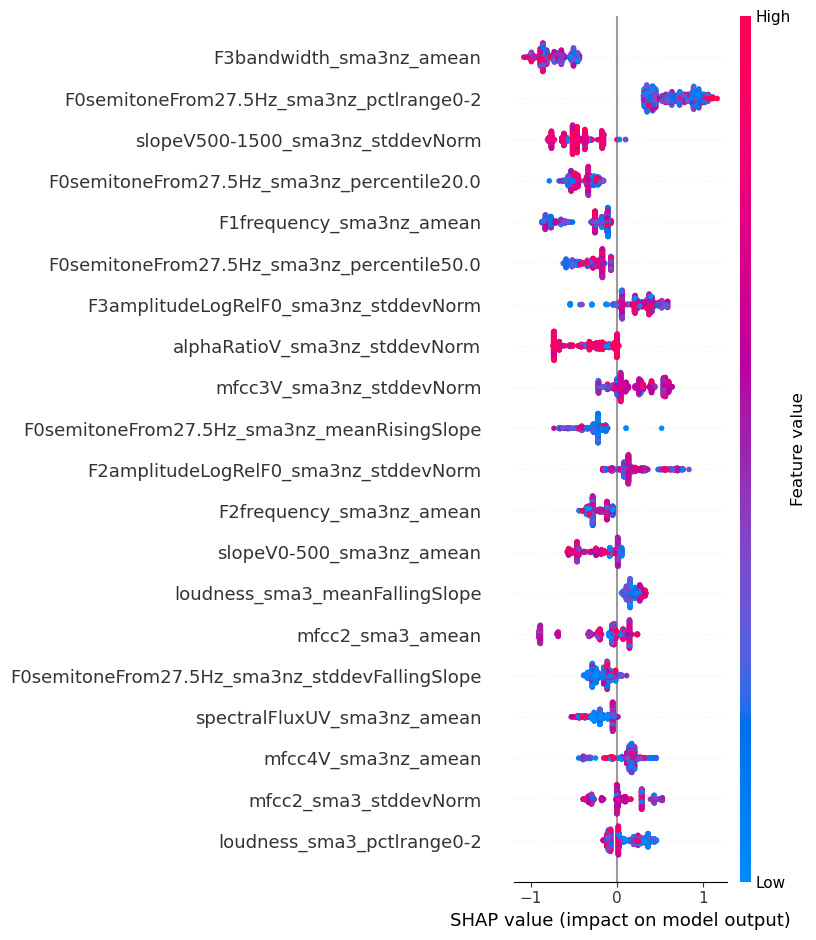

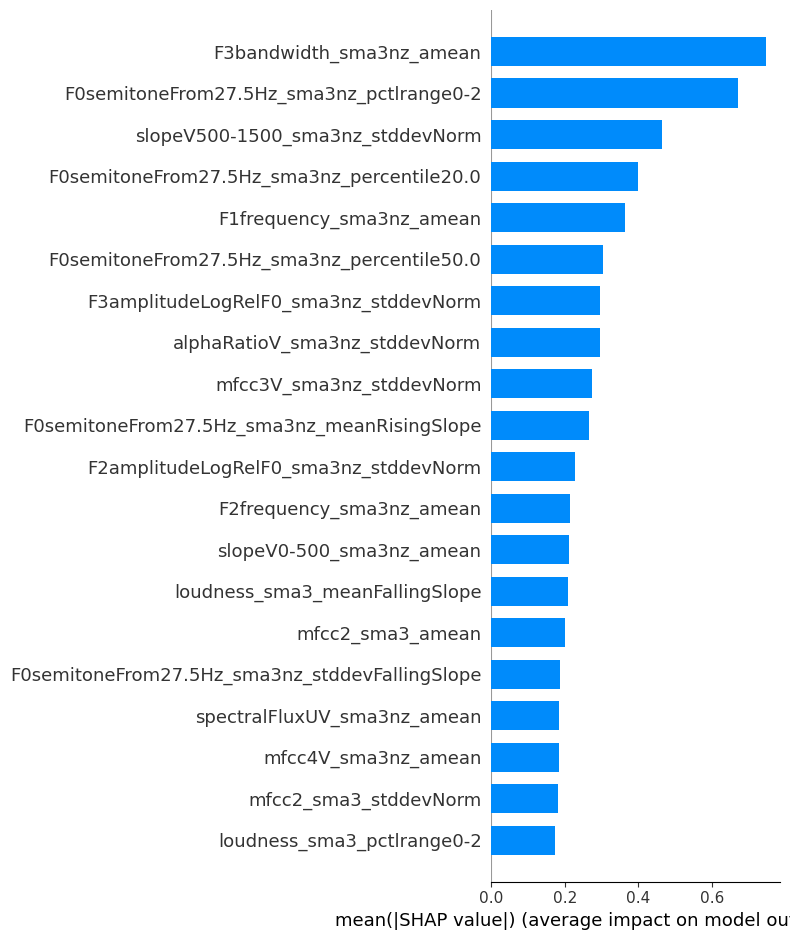

In [57]:
# SHAP Summary Plot
shap.summary_plot(shap_values_combined, features=X)
shap.summary_plot(shap_values_combined, features = X, plot_type="bar")

# English

In [58]:
X, y, groups, gkf, n_splits = separate_feats_labs(df_english)
feature_importances, shap_values_combined,_= evaluate_features(X, y, groups, gkf, n_splits)
# Feature-Importance DataFrame 
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# Top 10 Feature-Importances 
feature_importance_df.head(10)


,Feature,Importance
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.035939
87,equivalentSoundLevel_dBp,0.035909
10,loudness_sma3_amean,0.032129
5,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,0.032066
66,spectralFluxV_sma3nz_amean,0.031850
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.030775
45,F1amplitudeLogRelF0_sma3nz_stddevNorm,0.026145
76,alphaRatioUV_sma3nz_amean,0.021958
58,alphaRatioV_sma3nz_amean,0.021911
20,spectralFlux_sma3_amean,0.020957


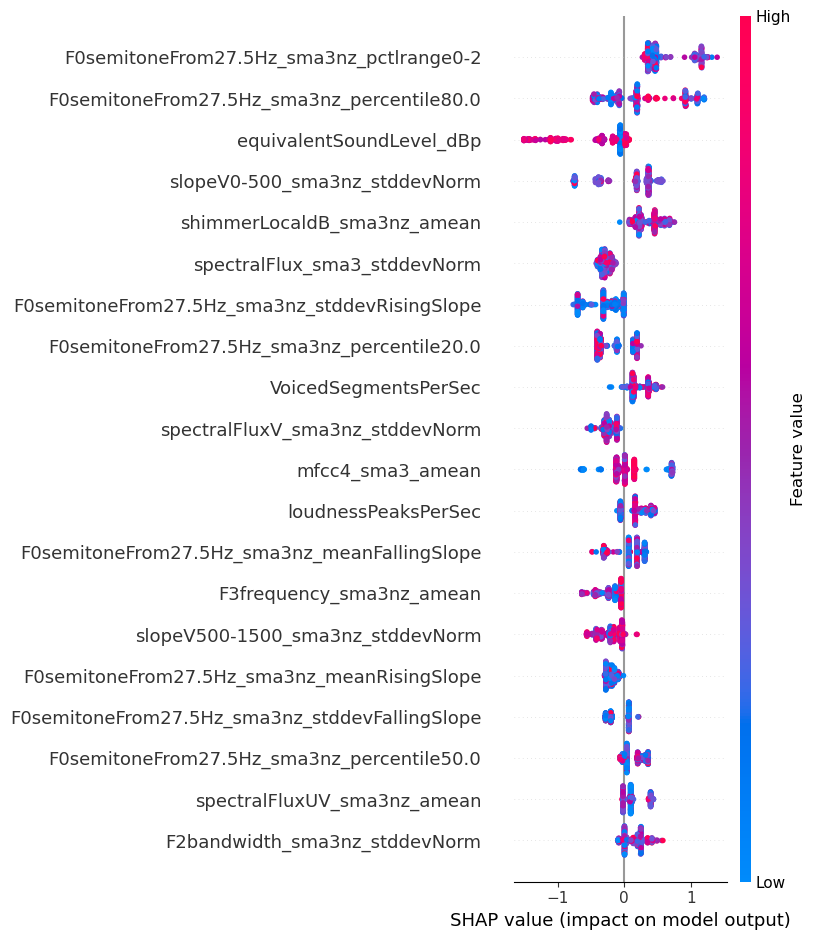

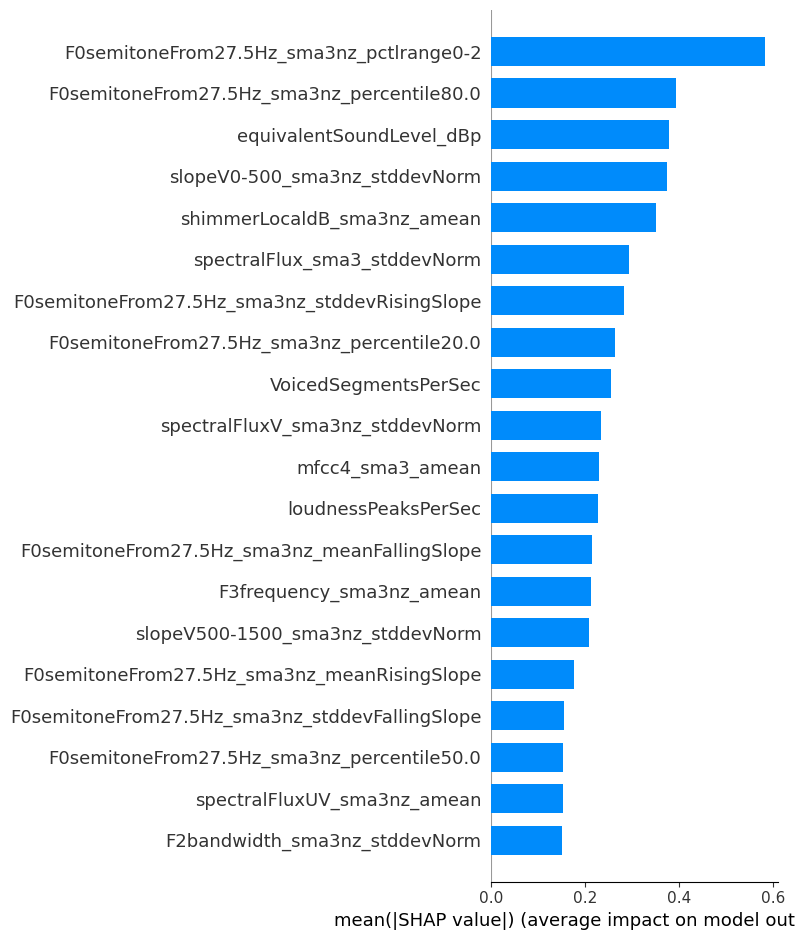

In [59]:
# SHAP Summary Plot
shap.summary_plot(shap_values_combined, features=X)
shap.summary_plot(shap_values_combined, features = X, plot_type="bar")

# Urdu

In [60]:
X, y, groups, gkf, n_splits = separate_feats_labs(df_urdu)
feature_importances, shap_values_combined,_= evaluate_features(X, y, groups, gkf, n_splits)
# Feature-Importance DataFrame 
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# Top 10 Feature-Importances 
feature_importance_df.head(10)


,Feature,Importance
26,mfcc3_sma3_amean,0.105921
78,slopeUV0-500_sma3nz_amean,0.043916
22,mfcc1_sma3_amean,0.042886
62,slopeV0-500_sma3nz_amean,0.038964
38,logRelF0-H1-A3_sma3nz_amean,0.031889
55,F3bandwidth_sma3nz_stddevNorm,0.030843
19,loudness_sma3_stddevFallingSlope,0.028836
20,spectralFlux_sma3_amean,0.028734
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.027890
14,loudness_sma3_percentile80.0,0.023539


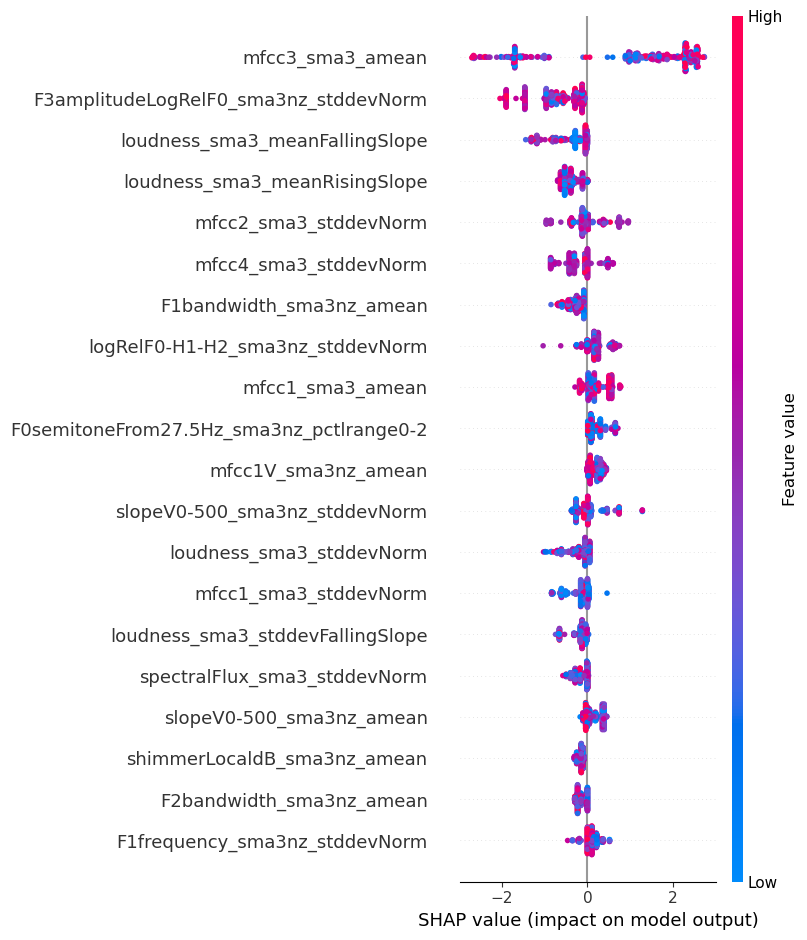

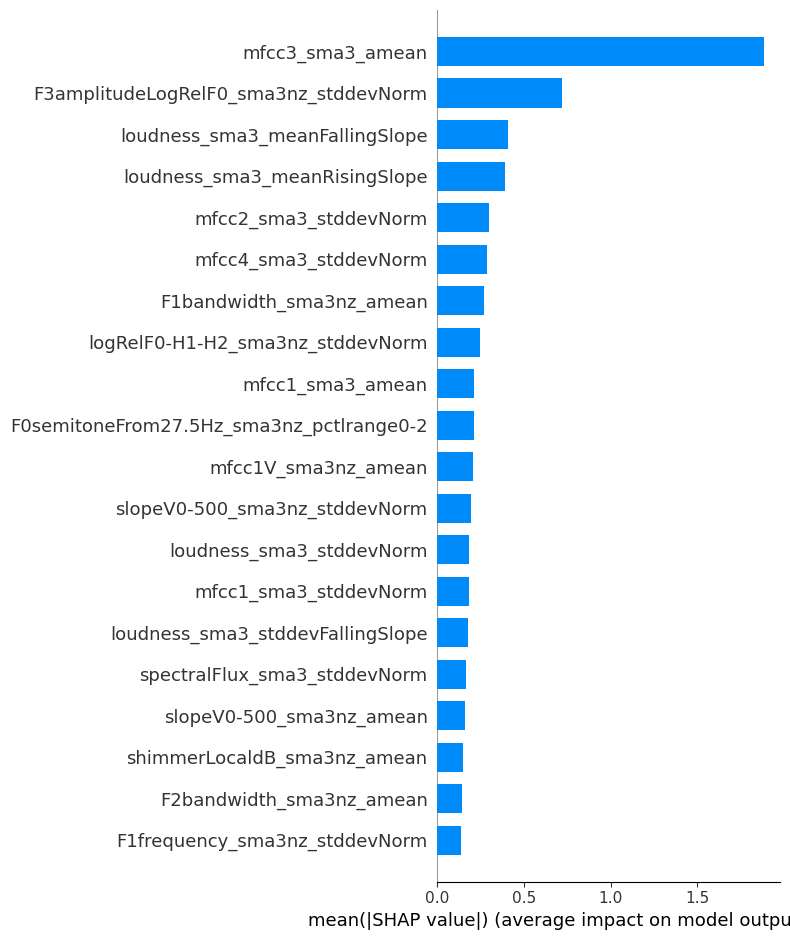

In [61]:
# SHAP Summary Plot
shap.summary_plot(shap_values_combined, features=X)
shap.summary_plot(shap_values_combined, features = X, plot_type="bar")

# Conclusion